### **Aplicações de Machine Learning com microdados do Enem 2021**

Objetivo do Projeto:

- Objetivo primário: explorar técnicas de feature selection e feature engineering na construção dos modelos de machine learning;

- Desenvolver múltiplos modelos de regressão que possam prever a nota final dos candidatos com base nas features selecionadas.

### **Sobre o DataSet:**

- Os dados orignais foram coletados no site oficial do [INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados).

- Para melhor desempenho computacional, optamos por selecionar apenas candidatos do Estado de São Paulo presentes em todas as provas do Enem e que não são considerados treineiros, ou seja, candidatos que realizam a prova apenas como teste de desempenho pessoal.

- Cada linha do dataset representa um candidato, seu desempenho em todas as provas além de suas informações pessoais (Sexo, Idade, Tipo de Escola e etc.)

- O dataset utilizado neste projeto pode ser encontrado [neste repositório](https://github.com/adautogaliza/enem2021_machine_learning). Lá temos os microdados originais e o dataset aqui proposto após o filtros e primeiros tratamentos realizados.

### **Conhecendo o DataSet e Primeiros Tratamentos**

In [412]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [413]:
# Importando dados

df = pd.read_csv('enem2021.csv',sep=';')
df.head()

,Unnamed: 0,NU_INSCRICAO,FAIXA_ETARIA,SEXO,ESTADO_CIVIL,COR_RACA,NACIONALIDADE,TIPO_ESCOLA,NO_MUNICIPIO_ESC,NOTA_CN,...,NOTA_COMP2,NOTA_COMP3,NOTA_COMP4,NOTA_COMP5,NOTA_REDACAO,ESCOLARIDADE_PAI,ESCOLARIDADE_MAE,QTDE_RESIDENTES_CASA,FAIXA_RENDA_FAMILIAR,ACESSO_INTERNET
0,63,210052097511,3,F,1,1,1,2,Sorocaba,679.2,...,120.0,140.0,140.0,160.0,720.0,D,C,2.0,B,B
1,71,210053495342,3,F,1,1,1,2,São Paulo,400.6,...,120.0,100.0,120.0,120.0,540.0,E,E,5.0,B,B
2,75,210053524905,2,F,1,1,1,2,São Bernardo do Campo,617.1,...,200.0,160.0,200.0,200.0,920.0,E,G,4.0,I,B
3,169,210051235712,2,F,1,1,1,2,Tietê,485.1,...,120.0,120.0,120.0,100.0,580.0,D,E,4.0,G,B
4,240,210051574300,2,F,1,3,1,2,Artur Nogueira,415.9,...,40.0,40.0,120.0,40.0,340.0,B,E,4.0,B,B


In [414]:
# Estrutura dos dados
df.shape

(113008, 25)

In [415]:
# Removendo coluna Unnamed: 0
df.drop('Unnamed: 0',inplace=True,axis=1)

In [416]:
# Tipagem das features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113008 entries, 0 to 113007
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NU_INSCRICAO          113008 non-null  int64  
 1   FAIXA_ETARIA          113008 non-null  int64  
 2   SEXO                  113008 non-null  object 
 3   ESTADO_CIVIL          113008 non-null  int64  
 4   COR_RACA              113008 non-null  int64  
 5   NACIONALIDADE         113008 non-null  int64  
 6   TIPO_ESCOLA           113008 non-null  int64  
 7   NO_MUNICIPIO_ESC      113008 non-null  object 
 8   NOTA_CN               113008 non-null  float64
 9   NOTA_CH               113008 non-null  float64
 10  NOTA_LC               113008 non-null  float64
 11  NOTA_MT               113008 non-null  float64
 12  TP_LINGUA             113008 non-null  int64  
 13  NOTA_COMP1            113008 non-null  float64
 14  NOTA_COMP2            113008 non-null  float64
 15  

Iremos modificar algumas features que são características dos candidatos (variáveis categóricas) representadas por números e que foram reconhecidas como variáveis numéricas.

In [417]:
filtro_categoricas = ['FAIXA_ETARIA','ESTADO_CIVIL','COR_RACA','NACIONALIDADE',
'TIPO_ESCOLA','TP_LINGUA']

df[filtro_categoricas] = df[filtro_categoricas].astype('object')

Agora iremos verificar o estado de dados ausentes do dataset

In [418]:
df.isnull().sum()

NU_INSCRICAO            0
FAIXA_ETARIA            0
SEXO                    0
ESTADO_CIVIL            0
COR_RACA                0
NACIONALIDADE           0
TIPO_ESCOLA             0
NO_MUNICIPIO_ESC        0
NOTA_CN                 0
NOTA_CH                 0
NOTA_LC                 0
NOTA_MT                 0
TP_LINGUA               0
NOTA_COMP1              0
NOTA_COMP2              0
NOTA_COMP3              0
NOTA_COMP4              0
NOTA_COMP5              0
NOTA_REDACAO            0
ESCOLARIDADE_PAI        0
ESCOLARIDADE_MAE        0
QTDE_RESIDENTES_CASA    0
FAIXA_RENDA_FAMILIAR    0
ACESSO_INTERNET         0
dtype: int64

In [419]:
# Não temos maiores problemas com valores ausentes, podemos excluir aqueles presentes
df.dropna(axis=0, inplace=True)

Nos nossos modelos de previsão de notas o objetivo é prever a ``Nota Final`` do candidato com base nas suas características. Para tanto, precisamos criar esta feature como uma média de todas as 5 avaliações (Nota em Ciências Naturais, Humanas, Letras e Códigos, Matemática e Redação)

In [420]:
df['NOTA_FINAL'] = (df['NOTA_CH'] + df['NOTA_CN'] + df['NOTA_LC'] + df['NOTA_MT'] + df['NOTA_REDACAO']) / 5

### **Analise Exploratória dos dados**

Primeiro vamos verificar um sumário estatístico das features quantitaivas:

In [421]:
# Filtro
cols_numerica = [coluna for coluna in df.columns if df[coluna].dtype in ['float64']]

# Sumário estatístico
df[cols_numerica].describe()

,NOTA_CN,NOTA_CH,NOTA_LC,NOTA_MT,NOTA_COMP1,NOTA_COMP2,NOTA_COMP3,NOTA_COMP4,NOTA_COMP5,NOTA_REDACAO,QTDE_RESIDENTES_CASA,NOTA_FINAL
count,113008.000000,113008.000000,113008.000000,113008.000000,113008.000000,113008.000000,113008.000000,113008.000000,113008.000000,113008.000000,113008.000000,113008.000000
mean,511.269891,544.382506,529.895267,573.777779,125.724020,144.061659,120.010442,133.079428,120.964710,643.840259,3.775299,560.633140
std,81.895338,87.423851,68.595534,110.528758,27.951331,40.888538,30.937117,32.959932,55.572388,162.012533,1.065240,83.143482
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,448.300000,483.000000,486.400000,482.900000,120.000000,120.000000,100.000000,120.000000,80.000000,560.000000,3.000000,500.420000
50%,506.400000,552.000000,534.000000,571.700000,120.000000,120.000000,120.000000,120.000000,120.000000,640.000000,4.000000,556.600000
75%,570.600000,605.300000,577.600000,655.300000,140.000000,180.000000,140.000000,160.000000,160.000000,760.000000,4.000000,618.245000
max,836.900000,846.900000,799.300000,953.100000,200.000000,200.000000,200.000000,200.000000,200.000000,1000.000000,20.000000,846.100000


In [422]:
# Definindo função para criação de boxplots e histogramas das features numéricas 

def plot_histbox(data):

 # Definindo o tamanho dos gráficos
 f, ax = plt.subplots ( figsize=(20,30) )
 cor_fundo = '#FFFFFF'
 f.set_facecolor( cor_fundo )
 # Esquema de cores
 paleta_cores = sns.color_palette( 'Dark2', len( data.columns ) * 2 )
 # Titulo Geral
 plt.suptitle( 'Boxplot e Histograma das Features Numéricas')
 # Estruturas para plotar os gráficos
 linhas = len(data.columns)
 colunas = 2 
 posicao = 1
 # Plotando os gráficos
 for coluna in data.columns:
    # Plot no Grid -- Boxplot
    plt.subplot( linhas, colunas, posicao )
    # Titulo
    plt.title( f'{coluna}', loc='left', fontsize=14, fontweight=200 )
    # Plot
    sns.boxplot( data=df, y=coluna, showmeans=True, saturation=0.75,
    linewidth=1, color=paleta_cores[ posicao ], width=0.25, )
    # Mudando de posicao
    posicao += 1
    # Plot no grid -- Distplot
    plt.subplot( linhas, colunas, posicao )
    # Titulo
    plt.title( f'{coluna}', loc='left', fontsize=14, fontweight=200 )
    # Plot
    sns.distplot( df[ coluna ], color=paleta_cores[ posicao - 1 ] )
    # Mudando de posicao
    posicao += 1
 # Ajustando o Grid
 plt.subplots_adjust( top=0.95, hspace=0.3 )

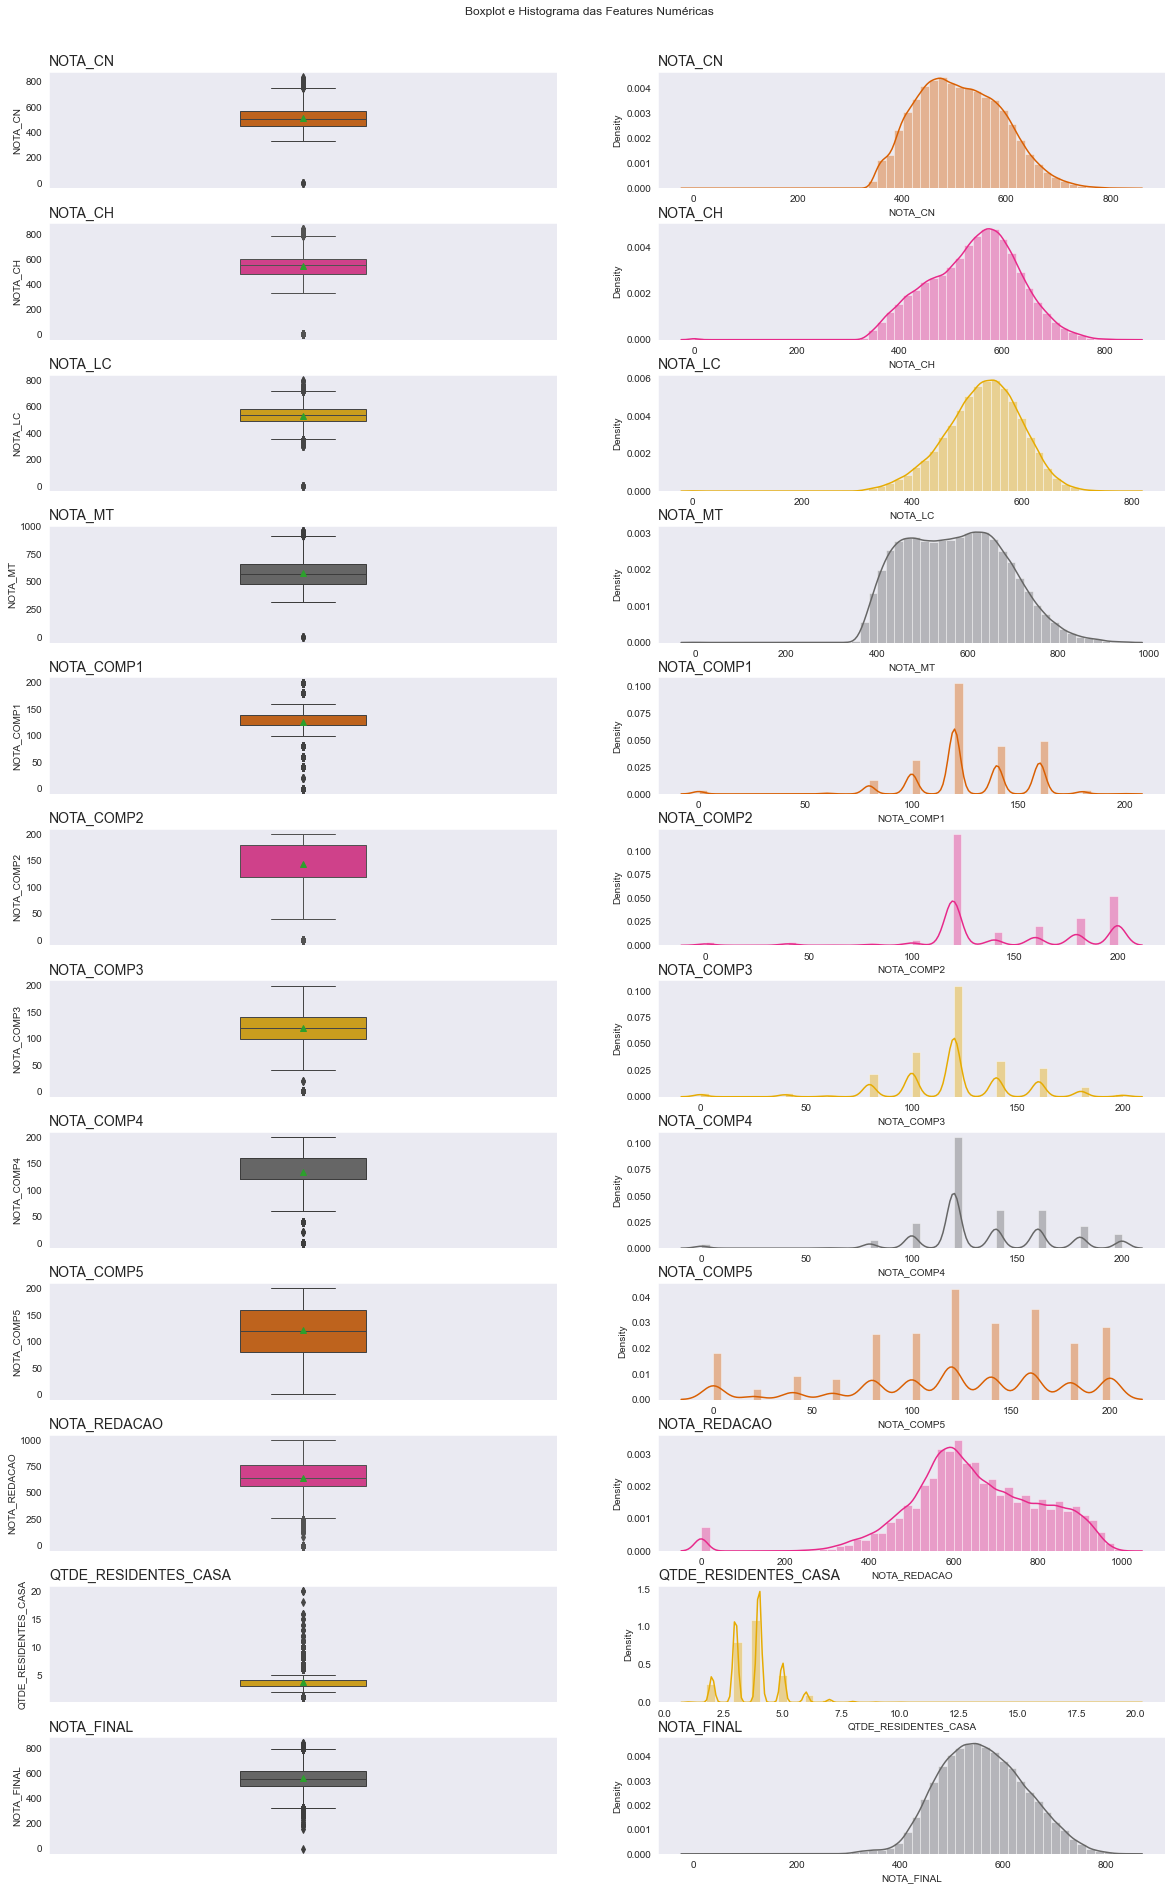

In [423]:
plot_histbox(df[cols_numerica])

**Impressões Gerais:**

- **Em todas as provas temos candidatos que as zeraram. Isto é particularmente verdade considerando que nosso dataset filtrou apenas aqueles candidatos que efetivamente estavam presentes no dia das respectivas provas.**

- **Nenhum vestibulando conseguiu nota máxima (1.000) nas provas objetivas, mas existem candidatos que obtiveram a pontuação máxima em Redação.**

- **Em termos de desempenho médio, no agregado os candidatos de São Paulo foram melhores em Redação (média de 643,8) e piores na prova de Ciências Naturais (511,2). Isto pode ser um indicativo para as escolas e os preparativos de que esta disciplina merece melhor atenção.**

- **Em relação a distribuição das features, podemos ver a existência de outliers em todas elas. A princípio, iremos preservar estes dados na modelagem dos algoritmos e posteriormente podemos ver a necessidade de removê-los. Ademais, os dados não apresentam valores "impossíveis" de existir ou fora de algum padrão esperado.**

Agora iremos buscar alguns insights sobre nossas variáveis categóricas:

Qual o desempenho em relação ao Sexo e o Tipo de Escola?

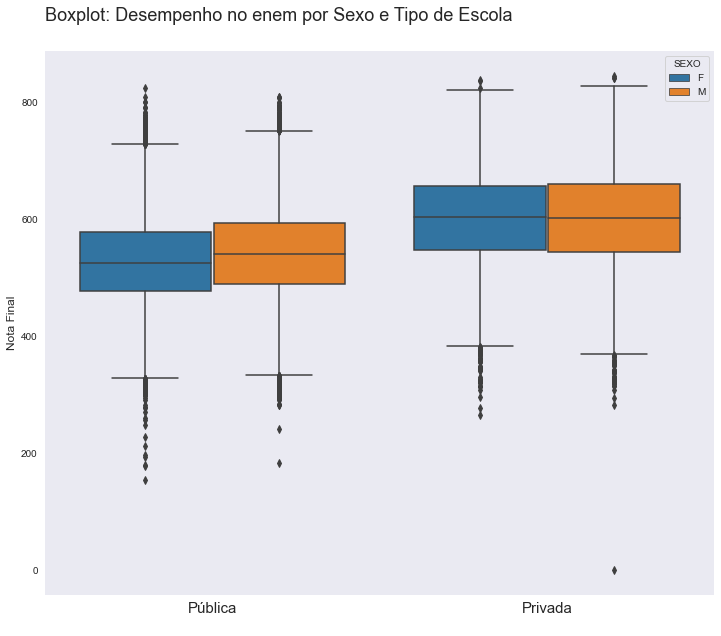

In [424]:
# Plotagem
g1_sexo_escola = sns.boxplot(y="NOTA_FINAL", x = "TIPO_ESCOLA", hue = "SEXO", palette="tab10", data=df)
g1_sexo_escola.figure.set_size_inches(12,10)
plt.title('Boxplot: Desempenho no enem por Sexo e Tipo de Escola', fontsize = 18, loc='left', pad=30)
plt.ylabel('Nota Final', fontsize=12)
plt.xlabel(' ')
plt.xticks(np.arange(0, 1, step=1))  # Informando a posição dos ticks.
plt.xticks(np.arange(2), [2 , 3], fontsize = 15)  # Informando os rótulos a serem alterados
plt.xticks([0, 1], ['Pública', 'Privada']) # Alterando o rótulo.
sns.despine (left = True)
sns.set_style('ticks')

**Impressões**:

- **Em geral o desempenho dos candidatos de escola privada é maior que os de escola pública, tanto para homens quanto mulheres**.

- **Quando analisamos os candidatos de escolas públicas, podemos ver que há uma diferença no desempenho entre os sexos, com os candidatos do sexo masculino com desempenho ligeiramente melhor que as candidatas**. 

- **Esta diferença é praticamente inexistente entre os sexos para os candidatos de escolas privadas. Tanto a mediana quanto a distribução interquartil são similares.**

- **Chama a antenção a quantidade de ouliers, tanto nos quartis superiores quanto inferiores, nos candidatos de escolas públicas. Os dados sugerem que há muitos alunos desempenhando muito bem e muito mal em relação a média. No entanto, embora existam muitos ouliers nos quartis inferiores para candidatos de escolas particulares, desempenhando mal, há maior uniformidade dos vestibulandos de alta performance independentemente do sexo.**

Qual o desempenho quando comparamos pela raça autodeclarada dos candidatos?

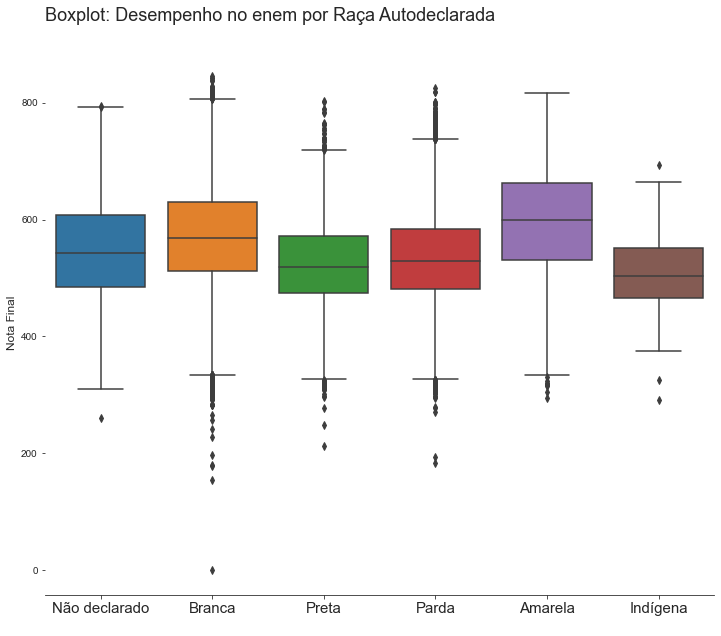

In [425]:
# Plotagem
g2_raca = sns.boxplot(y="NOTA_FINAL", x = "COR_RACA", palette="tab10", data=df)
g2_raca.figure.set_size_inches(12,10)
plt.title('Boxplot: Desempenho no enem por Raça Autodeclarada', fontsize = 18, loc='left', pad=30)
plt.ylabel('Nota Final', fontsize=12)
plt.xlabel(' ')
plt.xticks(np.arange(0, 5, step=1))  # Informando a posição dos ticks
plt.xticks(np.arange(6), [0, 1, 2, 3 , 4, 5], fontsize = 15)  # Informando os rótulos a serem alterados
plt.xticks([0, 1, 2, 3 , 4, 5], ['Não declarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena']) # Alterando o rótulo
sns.despine (left = True)
sns.set_style('ticks')

**Impressões**:

- **Candidatos autodeclarados brancos e amarelos desempenham melhor em relação aos demais. Este padrão está em conformidade com o histórico de desempenho pregresso neste tópico.**

- **Na outra ponta, índigenas e pretos possuem a pior média de desempenho entre os grupos.**

Há diferenças no desempenho entre os alunos com e sem acesso a internet?

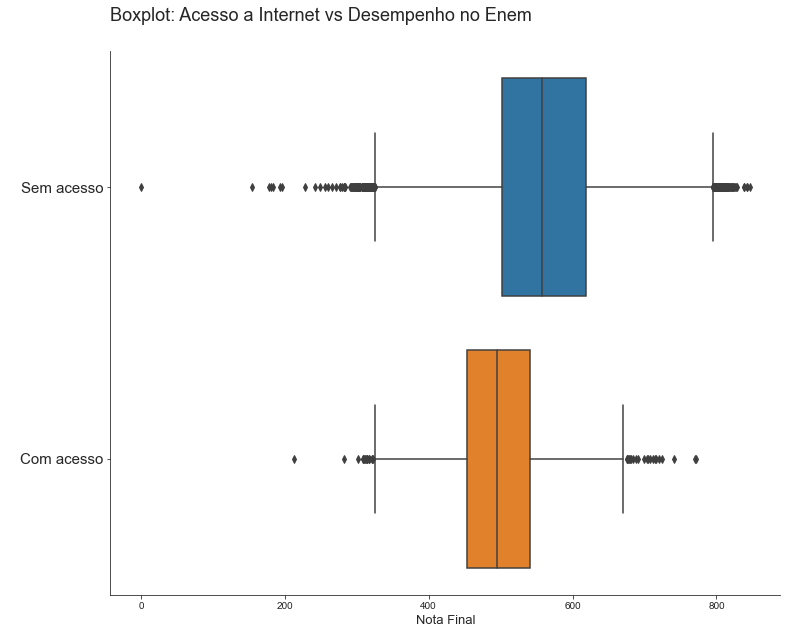

In [426]:
# Plotagem
g3_internet = sns.boxplot(y="ACESSO_INTERNET", x = "NOTA_FINAL", palette="tab10", data=df)
g3_internet.figure.set_size_inches(12,10)
plt.title('Boxplot: Acesso a Internet vs Desempenho no Enem', fontsize = 18, loc='left', pad=30)
plt.ylabel(' ')
plt.xlabel('Nota Final', fontsize=13)
plt.yticks(np.arange(0, 1, step=1))  # Informando a posição dos ticks
plt.yticks(np.arange(2), ['A', 'B'], fontsize = 15)  # Informando os rótulos a serem alterados
plt.yticks([0,1], ['Sem acesso', 'Com acesso']) # Alterando o rótulo
sns.despine (left = False)

**Impressões**:

- **Em geral os candidatos que não possuem acesso a internet em casa tendem a ter um desempenho melhor que aqueles com acesso. Surpreendentemente esta característica não parece ter influência no desempenho final do Enem**. 

Porque?

In [427]:
# Verificando tamanho dos grupos
df.groupby('ACESSO_INTERNET').size()

ACESSO_INTERNET
A      1533
B    111475
dtype: int64

A esmagadora maioria dos candidatos declara ter acesso a internet. Apenas 1.533 declaram não ter acesso, e isto pode explicar estas diferenças. Em geral, como o maior grupo de vestibulandos possuem acesso, isto englobará tanto candidatos com bom desempenho, quanto aqueles de menor desempenho, o que pode puxar a média para baixo.

Em relação a escolaridade do Pai e da Mãe, existem diferenças nos desempenhos dos candidatos?

In [428]:
# Iremos agrupar os dados originais para apenas 3 categorias: Até o Ensino Médio, Ensino Superior e Pós-graduação.
escolaridade_dict =  {
    'A' : 'Até o Ensino Médio',
    'B': 'Até o Ensino Médio',
    'C' : 'Até o Ensino Médio',
    'D' : 'Até o Ensino Médio',
    'E' : 'Até o Ensino Médio',
    'F' : 'Ensino superior',
    'G' : 'Pós-Graduação',
    'H' : 'Não informado'} # mapeando os grupos por um dicionário

# Aplicando o agrupamento
df['ESCOLARIDADE_PAI_AGREGADA'] = [escolaridade_dict[i] for i in df.ESCOLARIDADE_PAI] 
df['ESCOLARIDADE_MAE_AGREGADA'] = [escolaridade_dict[i] for i in df.ESCOLARIDADE_MAE]

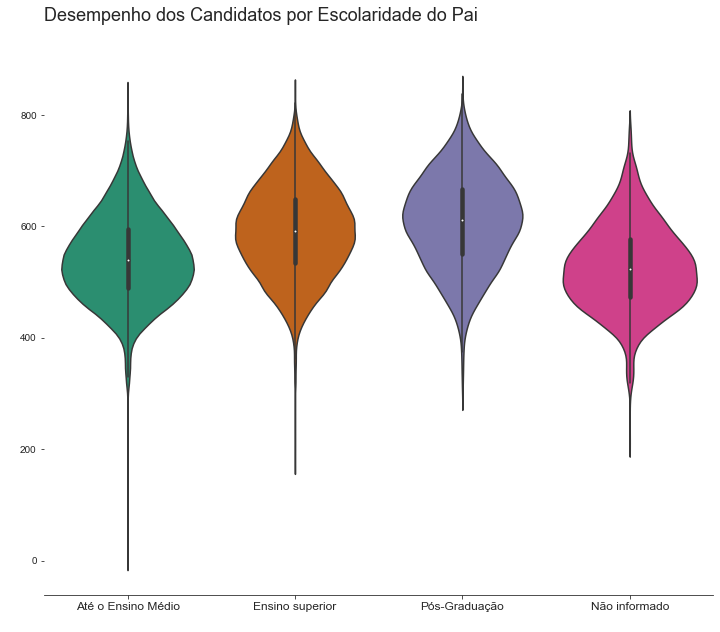

In [429]:
# Plotagem para escolaridade dos Pais
g4_escolaridade_pai = sns.violinplot(y="NOTA_FINAL", x = "ESCOLARIDADE_PAI_AGREGADA", palette="Dark2", data=df)
g4_escolaridade_pai.figure.set_size_inches(12,10)
plt.title('Desempenho dos Candidatos por Escolaridade do Pai', fontsize = 18, loc='left', pad=30)
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(fontsize = 12)
sns.despine (left = True)
sns.set_style('ticks')

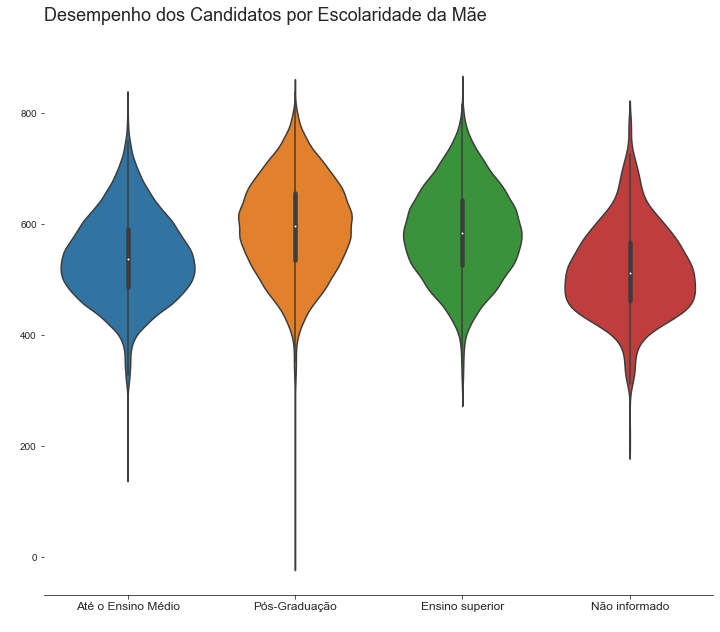

In [430]:
# Plotagem para escolaridade das Mães
g5_escolaridade_mae = sns.violinplot(y="NOTA_FINAL", x = "ESCOLARIDADE_MAE_AGREGADA", palette="tab10", data=df)
g5_escolaridade_mae.figure.set_size_inches(12,10)
plt.title('Desempenho dos Candidatos por Escolaridade da Mãe', fontsize = 18, loc='left', pad=30)
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(fontsize = 12)
sns.despine (left = True)
sns.set_style('ticks')

**Impressões**:

- **O desempenho dos candidatos melhora sistematicamente quanto maior é a escolaridade do pai**.

- **Entretanto, quando olhamos para a escolaridade da mãe o padrão não é linear. O desemepnho melhora entre a escolaridade de ensino médio e superior, mas há pequena piora no grupo de mães com pós-graduação.**



Estes efeitos são explicados pelo tamanho do grupo como no caso do acesso a internet? O agrupamento a seguir indica que provavelmente não, pois o agrupamento de candidatos com mães com pós-graduação é relativamente próximo daquelas com ensino superior, não sendo um diferença tão extrema como no exemplo de acesso à internet.

In [431]:
df.groupby(['ESCOLARIDADE_MAE_AGREGADA']).size()

ESCOLARIDADE_MAE_AGREGADA
Até o Ensino Médio    64106
Ensino superior       27178
Não informado          1734
Pós-Graduação         19990
dtype: int64

Candidatos mais experientes possuem desempenho melhor que candidatos mais novos?

In [432]:
def faixa_etaria_agrup(df):
    """Esta função irá criar uma nova coluna no dataset com os
    valores definidos como menor que 17 anos, entre 17 e 30 e etc."""
    # Lista com os valores a serem substituídos
    Menor_17_anos = 1
    entre_17_30_anos = np.arange(2,11)
    acima_30_anos = np.arange(12,20)

    # Condições para aplicar a substituição 
    if df["FAIXA_ETARIA"] == Menor_17_anos:
        return "Menor que 17 anos"
    elif df["FAIXA_ETARIA"] in entre_17_30_anos:
        return "Entre 17 e 30 anos"
    else:
        return "Acima de 30 anos" 

# Aplicando as substituições       
df["FAIXA_ETARIA_AGRUPADA"] = df.apply(faixa_etaria_agrup, axis=1)

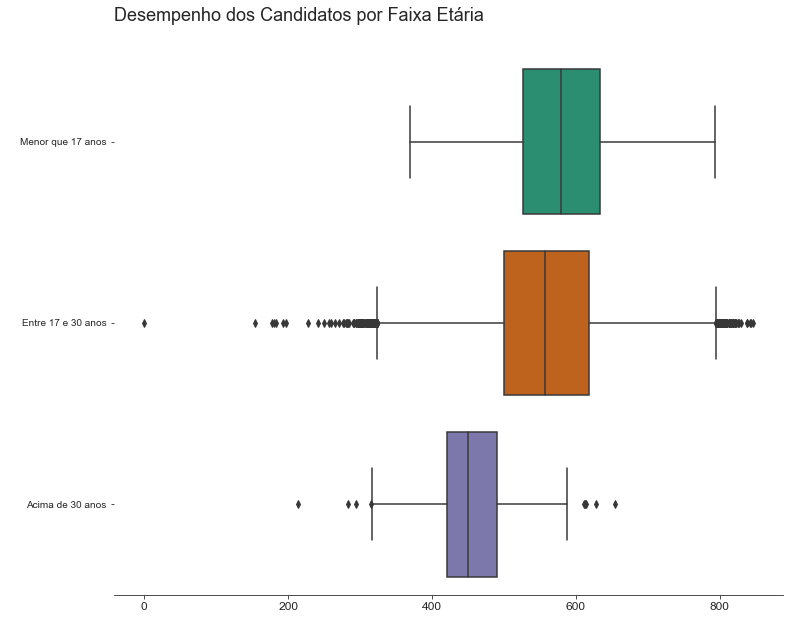

In [433]:
# Plotagem para escolaridade das Mães
g6_faixa_etaria = sns.boxplot(y="FAIXA_ETARIA_AGRUPADA", x = "NOTA_FINAL", 
    palette="Dark2", data=df, order=['Menor que 17 anos','Entre 17 e 30 anos','Acima de 30 anos'])
g6_faixa_etaria.figure.set_size_inches(12,10)
plt.title('Desempenho dos Candidatos por Faixa Etária', fontsize = 18, loc='left', pad=30)
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(fontsize = 12)
sns.despine (left = True)
sns.set_style('ticks')

**Impressões:**

- **Candidatos mais novos (< 17 anos) possuem desempenho relativamente melhor que os demais grupos. Isto pode indicar que aqueles concorrentes recém saídos do ensino médio possuem ligeira vantagem em relação aos seus pares.**

- **No entanto, na faixa intermediária de candidatos é possível observar uma grande quantidade de ouliers nas duas extremidades da IQR. Ademais, candidatos acima de 30 anos possuem uma performance bem abaixo daquele primeiro grupo.**

In [434]:
def renda_agrupada(df):
    """Esta função irá criar uma nova coluna no dataset com as
    novas faixas definidas abaixo."""
    # Lista com os valores a serem substituídos
    renda_baixa = ['B','C','D','E','F','G','H']
    renda_intermediaria = ['I','J','K','L','M']

    # Condições para aplicar a substituição 
    if df["FAIXA_RENDA_FAMILIAR"] == 'A':
        return "Sem renda"
    elif df["FAIXA_RENDA_FAMILIAR"] in renda_baixa:
        return "Entre 1.000 e 5.500"
    elif df["FAIXA_RENDA_FAMILIAR"] in renda_intermediaria:
        return "Entre 5.501 e 11.000"
    else:
        return "Acima de 11.000" 

# Aplicando as substituições       
df["FAIXA_RENDA_AGRUPADA"] = df.apply(renda_agrupada, axis=1)

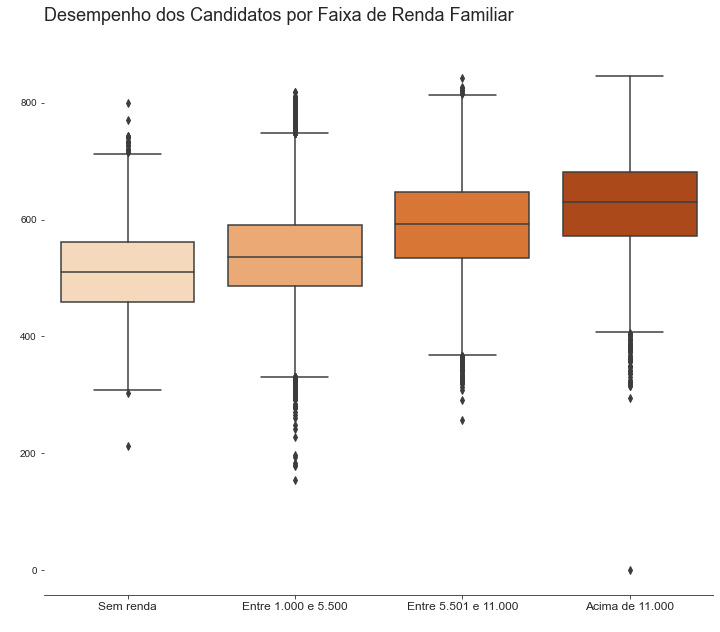

In [435]:
# Plotagem para faixas de renda
g7_faixa_renda = sns.boxplot(y="NOTA_FINAL", x = "FAIXA_RENDA_AGRUPADA", 
    palette="Oranges", data=df, order=['Sem renda','Entre 1.000 e 5.500','Entre 5.501 e 11.000', 'Acima de 11.000'])
g7_faixa_renda.figure.set_size_inches(12,10)
plt.title('Desempenho dos Candidatos por Faixa de Renda Familiar', fontsize = 18, loc='left', pad=30)
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(fontsize = 12)
sns.despine (left = True)
sns.set_style('ticks')

**Impressões:**

- **Há uma clara tendência de aumento das notas finais quanto maior é o extrato de renda familiar do candidato**

- **Uma observação interessante são os outliers do quartil superior dos 3 primeiros grupos: estes candidatos, apesar de estarem fora da curva, possuem desempenho apenas similar aqueles candidatos do grupo de maior renda ( > 11mil). Isto reforça o argumento de que a renda é um forte componete do desempenho dos alunos, pois fornece acesso a boas instituições de ensino, professores de alta qualidade, acesso a livros e demais materiais auxiliares no aprendizado**

### **Modelagem dos Regressores:**

- **Nosso objetivo é contruir um modelo que seja capaz de prever a ``Nota Final`` do candidato com base nas suas inforamções como Sexo, Tipo de Escola, Idade, Escolaridade do Pai, Renda Familiar e etc.**

- **Para tal, nossa estratégia é trabalhar com modelos lineares e de árvores usando algoritmos de tunning dos hiperparâmetros para encontrar os melhores resultados.**

- **Além disto, utilizaremos algumas técnicas de seleção de features do tipo univariada. Iremos também utilizar clusterização para criar novas features aos modelos regressivos.**

### **Selecionando Target e Features**

- **Nosso target é a variável NOTA_FINAL, que é uma média entre todas as disciplinas do Enem. É este o alvo das previsões do nosso modelo**

- **Para evitarmos problemas de data leakeage e ruídos nos modelos, precisamos retirar algumas features do dataset: Todas as ``notas individualizadas`` das disciplinas, por motivos óbvios, além do identificador `NU_INSCRICAO` que serve apenas para identificar os candidatos e das colunas criadas para montar a análise exploratória, como `ESCOLARIDADE_PAI_AGREGADA` e etc.**

In [436]:
# Filtro
remover_colunas = ['NU_INSCRICAO','NOTA_CN','NOTA_CH', 'NOTA_LC', 'NOTA_MT',  'NOTA_COMP1',
       'NOTA_COMP2', 'NOTA_COMP3', 'NOTA_COMP4', 'NOTA_COMP5', 'NOTA_REDACAO', 'ESCOLARIDADE_PAI_AGREGADA', 'ESCOLARIDADE_MAE_AGREGADA']
# Removendo colunas
df.drop(remover_colunas, axis=1,inplace=True)

In [437]:
X = df.drop(['NOTA_FINAL'],axis=1)
y = df['NOTA_FINAL']

### **Feature Engineering:**



Antes de proceder para a modelagem, precisamos investigar a cardinaldiade das features categóricas. Variáveis com um número maior que 10 a 15 classes podem apresentar problemas de performance, especialmente nos casos em que aplicaremos o ``OneHotEncoding()``.

O código adiante revela que precisamos lidar com a variável `NO_MUNICIPIO_ESC`, `FAIXA_ETARIA` e  `FAIXA_RENDA_FAMILIAR`. Para o problemas das duas últimas podemos simplesmente utilizar as categorias agrupadas daquelas classes da parte de análise exploratória dos dados, como uma forma de reduzir o número de categorias sem perder informação. Mas para o caso dos municípios, esta estratégia não é possível.

In [438]:
df.nunique()

FAIXA_ETARIA                20
SEXO                         2
ESTADO_CIVIL                 5
COR_RACA                     6
NACIONALIDADE                5
TIPO_ESCOLA                  2
NO_MUNICIPIO_ESC           615
TP_LINGUA                    2
ESCOLARIDADE_PAI             8
ESCOLARIDADE_MAE             8
QTDE_RESIDENTES_CASA        18
FAIXA_RENDA_FAMILIAR        17
ACESSO_INTERNET              2
NOTA_FINAL               27228
FAIXA_ETARIA_AGRUPADA        3
FAIXA_RENDA_AGRUPADA         4
dtype: int64

Iremos aplicar transformações aplicando a média da Nota Final por Municíoio pelo método de Smoothing. Este método irá imputar uma média para as classes de nossa feature baseado numa média ponderada pela "média intraclasse" e pela média geral do nosso target.

Obs: Para aplicação desta técnica é necessário sacrificar uma parte dos dados para o devido treinamento do encoding (e evitar data leakage). Iremos utilizar 20% dos dados para este objetivo, portanto o treinamento posterior do nosso modelo será feito com um dataset de 80% do tamanho do dataset original.

In [439]:
from category_encoders import MEstimateEncoder

# Separação dos dados para o encoding (20%  dataset)
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("NOTA_FINAL")

# Separação para treinar o encoder (80% dataset)
X_pretrain = df.drop(X_encode.index)
y = X_pretrain.pop("NOTA_FINAL")

# Selecionando features a serem transformadas e configurando a suaviação (m)
encoder = MEstimateEncoder(cols=['NO_MUNICIPIO_ESC'], m=5)

# Realizando fit
encoder.fit(X_encode,y_encode)

# Aplicando transformação nos dados de treino
X = encoder.transform(X_pretrain, y)

Agora iremos remover as colunas originais de Renda e Faixa etária, preservando apenas as features derivadas desta na parte de EDA.

In [440]:
X.drop(['FAIXA_ETARIA', 'FAIXA_RENDA_FAMILIAR'], axis=1,inplace=True)

In [441]:
X.columns

Index(['SEXO', 'ESTADO_CIVIL', 'COR_RACA', 'NACIONALIDADE', 'TIPO_ESCOLA',
       'NO_MUNICIPIO_ESC', 'TP_LINGUA', 'ESCOLARIDADE_PAI', 'ESCOLARIDADE_MAE',
       'QTDE_RESIDENTES_CASA', 'ACESSO_INTERNET', 'FAIXA_ETARIA_AGRUPADA',
       'FAIXA_RENDA_AGRUPADA'],
      dtype='object')

**Agora aplicaremos a clusterização de candidatos agrupados por similaridade como feature ao nosso dataset com o algorimo Kmeans**

In [442]:
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
features = X.columns

# Aplicando padronização: kmeans é sensivel as escalas
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

X_scaled.fillna(0,axis=0,inplace=True) # a transformação cria zeros e o phyton reconhece como NaN

# Instanciando modelo
kmeans = KMeans()

Para evitar arbitrariedade na escolha dos hiperparêmtros, iremos usar o RandomizedSearchCV() para esta tarefa:

In [443]:
# Selecionando hiperparâmetros
param_grid_clf_kmeans = {'n_clusters': [1, 3, 5],
'n_init': [10, 100],
'algorithm' : ['lloyd', 'elkan']}

# Instanciando a validação cruzada com 4 folds
kfold = KFold(n_splits = 4, random_state = 0, shuffle = True)

# Aplicando o RandomizedSearchCV() para seleção de melhores hiperparâmetros
clf_kmeans = RandomizedSearchCV(estimator = kmeans,
param_distributions = param_grid_clf_kmeans,
random_state = 0,
n_iter = 100,
n_jobs = -1,
verbose = 3,
cv = kfold)

In [444]:
# Realizando Fit
clf_kmeans.fit(X_scaled)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=0, shuffle=True),
                   estimator=KMeans(), n_iter=100, n_jobs=-1,
                   param_distributions={'algorithm': ['lloyd', 'elkan'],
                                        'n_clusters': [1, 3, 5],
                                        'n_init': [10, 100]},
                   random_state=0, verbose=3)

Quais os melhores hiperparâmetros?

In [445]:
clf_kmeans.best_params_

{'n_init': 10, 'n_clusters': 5, 'algorithm': 'elkan'}

Agora iremos aplicar os clusters em cada observação utilizando o modelo com estes parâmetros:

In [446]:
kmeans = KMeans(n_init = 10, n_clusters = 5, algorithm = 'elkan', random_state=0)
X["CLUSTER"] = kmeans.fit_predict(X_scaled)

Quantos candidatos foram alocados em cada cluster?

In [447]:
X["CLUSTER"].value_counts()

4    29339
1    25702
3    19270
0    15556
2      539
Name: CLUSTER, dtype: int64

Quais clusters abrigam candidatos com maior e menor desemepenho?

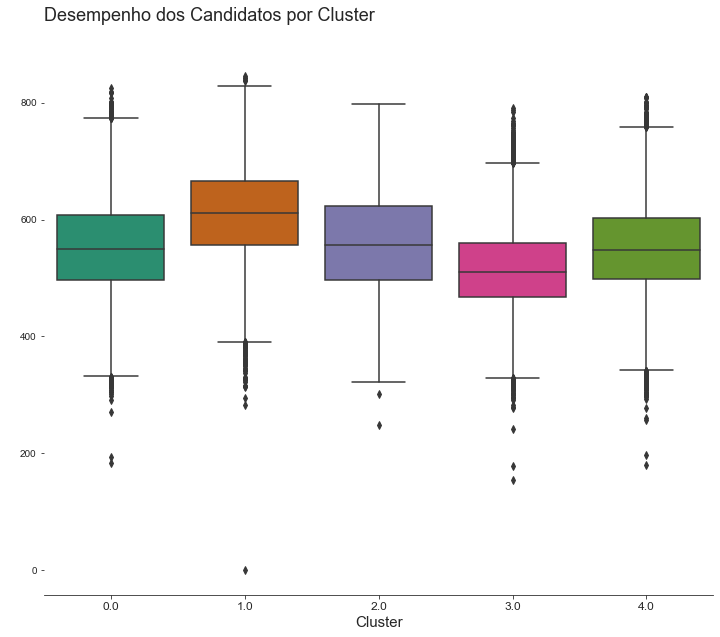

In [448]:
# Juntando os dados de cluster com nota final
x_concat = pd.concat([df['NOTA_FINAL'], X['CLUSTER']], axis=1, ignore_index=True)

# Plotando Gráfico
gf_cluster = sns.boxplot(y=0, x = 1, palette="Dark2", data=x_concat)
gf_cluster.figure.set_size_inches(12,10)
plt.title('Desempenho dos Candidatos por Cluster', fontsize = 18, loc='left', pad=30)
plt.ylabel(' ')
plt.xlabel('Cluster',fontsize = 15)
plt.xticks(fontsize = 12)
sns.despine (left = True)
sns.set_style('ticks')

Quais as características dominantes dos candidatos do Cluster 1 em relação a sua raça, sexo e faixa de renda?

In [450]:
# Por cor/raça
X.groupby(['CLUSTER', 'COR_RACA']).size()

CLUSTER  COR_RACA
0        2               3
         3           13476
         4            1933
         5             144
1        0             316
         1           24697
         2             689
2        0              19
         1             242
         2              31
         3              90
         4             144
         5              13
3        0             237
         1           11365
         2            1823
         3            5561
         4             284
4        0             482
         1           25341
         2            3516
dtype: int64

In [451]:
# Por sexo
X.groupby(['CLUSTER', 'SEXO']).size()

CLUSTER  SEXO
0        F        8204
         M        7352
1        F       13477
         M       12225
2        F         287
         M         252
3        F       12922
         M        6348
4        F       15793
         M       13546
dtype: int64

In [452]:
# Por renda
X.groupby(['CLUSTER', 'FAIXA_RENDA_AGRUPADA']).size()

CLUSTER  FAIXA_RENDA_AGRUPADA
0        Acima de 11.000          1128
         Entre 1.000 e 5.500     11804
         Entre 5.501 e 11.000     2443
         Sem renda                 181
1        Acima de 11.000          8436
         Entre 1.000 e 5.500      8874
         Entre 5.501 e 11.000     8301
         Sem renda                  91
2        Acima de 11.000            91
         Entre 1.000 e 5.500       347
         Entre 5.501 e 11.000       88
         Sem renda                  13
3        Acima de 11.000           583
         Entre 1.000 e 5.500     16062
         Entre 5.501 e 11.000     2335
         Sem renda                 290
4        Acima de 11.000          1027
         Entre 1.000 e 5.500     23649
         Entre 5.501 e 11.000     4345
         Sem renda                 318
dtype: int64

**Impressões:**

No cluster 1 temos, em sua maioria, candidatos autodeclarados brancos, de familias com renda acima de 5mil por mês, mas sem maiores distinções de sexo.

### **Criando e Treinenado os Modelos Regressivos**

Objetivo: Criar um modelo que possa prever a Nota Final do candidato baseado nas features selecionadas e criadas na etapa de Feature engineering

- Para tanto, iremos criar dois modelos na tentativa de selecionar aquele com as melhores métrica de desempenho (MAE, MSE E RMSE). Usaremos um modelo baseado em árvores de decisão (random forest) e um modelo linear regularizado (elasticnet)

- O 1º passo será aplicar uma tarefa de seleção de hiperparâmetros em ambos modelos. Após a identificação destes, iremos utilizá-los para rodar nosso modelo dentro de um pipeline em que executaremos cada modelo dentro de cada fold da cross-validation 5 vezes. Tomaremos esta tarefa com o objetivo de dar mais consistências nas nossas previsões. 

In [453]:
# Bibliotecas para modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [454]:
# Separando os dados em treino e teste para aplicação do tunning de hiperparâmetros
X_treino_search, X_teste_search, y_treino_search, y_teste_search = train_test_split(X,y,train_size=0.7,random_state=0)

Aplicando a padronização e OneHotEncoder nos dados com o método de ``pipeline``.

In [455]:
# Lista de features numéricas
cols_numerica = [coluna for coluna in X_treino_search.columns if X_treino_search[coluna].dtype in ['int64', 'float64', 'int32']]

# Lista de features categoricas
cols_categorica = [coluna for coluna in X_treino_search.columns if X_treino_search[coluna].dtype == "object"]

# Instanciando transformador numérico:
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())
])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Instanciando o pre-processador
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)])

# Pipeline para transformações numéricas e categóricas
pipeline_processador = Pipeline(steps=[('processador', processador)])

# Aplicando transformações
X_treino_search = pipeline_processador.fit_transform(X_treino_search)
X_teste_search = pipeline_processador.fit_transform(X_teste_search)

Criando um conjunto de hiperparâmeros a serem testados para ambos os modelos. Por motivos computacionais, iremos priorizar modelos mais simplificados com menor carga e peso de parâmetros.

In [456]:
# Random Forest
param_grid_forest = {'n_estimators': [10,50],
'max_depth': [10,50,100]}

# Elastic Net
param_grid_net = {'alpha': [0, 0.5, 1],
'l1_ratio': [0, 0.5, 1],
'max_iter': [10, 50, 100, 1000]}

Instanciando modelos:

In [457]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

# Random Forest
reg_rf = RandomForestRegressor()

# Elastic Net
reg_elastic = ElasticNet()

Aplicação do ``RandomizedSearchCV()`` para encontrar a melhor combinação de parâmetros:

In [458]:
# Aplicaremos uma cross-validation nesta tarefa

cv = KFold(n_splits=4, random_state=0, shuffle=True)

In [459]:
# Random Forest
search_reg_rf = RandomizedSearchCV(estimator = reg_rf,
param_distributions = param_grid_forest,
random_state = 0,
n_iter = 100,
n_jobs = -1,
verbose = 3,
cv = cv)

# Elastic Net
search_reg_elastic = RandomizedSearchCV(estimator = reg_elastic,
param_distributions = param_grid_net,
random_state = 0,
n_iter = 100,
n_jobs = -1,
verbose = 3,
cv = cv)

In [460]:
# Treinando modelo RandomForest
search_reg_rf.fit(X_treino_search, y_treino_search)

# Treinando o modelo ElastiNet
search_reg_elastic.fit(X_treino_search, y_treino_search)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 36 candidates, totalling 144 fits


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=0, shuffle=True),
                   estimator=ElasticNet(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0, 0.5, 1],
                                        'l1_ratio': [0, 0.5, 1],
                                        'max_iter': [10, 50, 100, 1000]},
                   random_state=0, verbose=3)

In [461]:
# Verificando melhores parâmetros de RandomForest
search_reg_rf.best_params_

{'n_estimators': 50, 'max_depth': 10}

In [462]:
# Melhores paraâmetros para ElatiscNet
search_reg_elastic.best_params_

{'max_iter': 50, 'l1_ratio': 0, 'alpha': 0}

Agora iremos rodar nosso modelos com os parâmetros selecionados pelo `RandomizedSearchCV()` com técnicas de seleção de features. Usaremos o método ``SelectKBest()`` do sklearn para monitorarmos o desempenho de ambos os modelos com a dimensionalidade imposta a eles. 

``SelectKBest()`` para o modelo RandomForest

In [463]:
# Loop para comparar os scores com base na quantidade de features selecionadas pelo algoritmo  SelectKBest
k_vs_scores = []
lista_mae = []
lista_mse = []
lista_rmse = []
for k in range(2,50,5):

    # Atribuindo o algoritmo de seleção de features
    seletor_RF = SelectKBest(score_func=f_regression, k = k)  

    Xtreino2 = seletor_RF.fit_transform(X_treino_search,y_treino_search)
    Xteste2 = seletor_RF.transform(X_teste_search)

    # Criando o modelo com os parâmetros selecionados 
    modelo_RF = RandomForestRegressor(n_estimators= 50, max_depth = 10, random_state=0)
    modelo_RF.fit(Xtreino2,y_treino_search)

    previsao = modelo_RF.predict(Xteste2)

    # Calculando métricas para cada rodada
    MAE = mean_absolute_error(y_teste_search, previsao)
    lista_mae.append(MAE)

    MSE = mean_squared_error(y_teste_search, previsao)
    lista_mse.append(MSE)

    RMSE = np.sqrt(MSE)
    lista_rmse.append(RMSE)
    print('Com k = {} o MAE = {}, o MSE = {} e o RMSE = {}'.format(k,round(MAE,2),round(MSE,2),round(RMSE,2)))

k_vs_scores.append(MAE)

Com k = 2 o MAE = 62.36, o MSE = 5992.81 e o RMSE = 77.41
Com k = 7 o MAE = 58.81, o MSE = 5404.72 e o RMSE = 73.52
Com k = 12 o MAE = 58.04, o MSE = 5291.21 e o RMSE = 72.74
Com k = 17 o MAE = 57.75, o MSE = 5237.47 e o RMSE = 72.37
Com k = 22 o MAE = 57.75, o MSE = 5232.71 e o RMSE = 72.34
Com k = 27 o MAE = 57.66, o MSE = 5221.64 e o RMSE = 72.26
Com k = 32 o MAE = 57.49, o MSE = 5194.28 e o RMSE = 72.07
Com k = 37 o MAE = 57.44, o MSE = 5182.27 e o RMSE = 71.99
Com k = 42 o MAE = 57.44, o MSE = 5181.42 e o RMSE = 71.98
Com k = 47 o MAE = 57.44, o MSE = 5181.09 e o RMSE = 71.98


``SelectKBest()`` para o modelo ElasticNet

In [464]:
# Loop para comparar os scores com base na quantidade de features selecionadas pelo algoritmo  SelectKBest
k_vs_scores = []
lista_mae = []
lista_mse = []
lista_rmse = []
for k in range(2,50,5):

    # Atribuindo o algoritmo de seleção de features
    seletor_ELASTIC = SelectKBest(score_func=f_regression, k = k)  

    Xtreino2 = seletor_ELASTIC.fit_transform(X_treino_search,y_treino_search)
    Xteste2 = seletor_ELASTIC.transform(X_teste_search)

    # Criando o modelo com os parâmetros selecionados 
    modelo_ELASTIC = ElasticNet(max_iter = 50, l1_ratio = 0, alpha = 0, random_state=0)
    modelo_ELASTIC.fit(Xtreino2,y_treino_search)

    previsao = modelo_ELASTIC.predict(Xteste2)

    # Calculando métricas para cada rodada
    MAE = mean_absolute_error(y_teste_search, previsao)
    lista_mae.append(MAE)

    MSE = mean_squared_error(y_teste_search, previsao)
    lista_mse.append(MSE)

    RMSE = np.sqrt(MSE)
    lista_rmse.append(RMSE)
    print('Com k = {} o MAE = {}, o MSE = {} e o RMSE = {}'.format(k,round(MAE,2),round(MSE,2),round(RMSE,2)))

k_vs_scores.append(MAE)

Com k = 2 o MAE = 62.36, o MSE = 5992.86 e o RMSE = 77.41
Com k = 7 o MAE = 58.86, o MSE = 5415.11 e o RMSE = 73.59
Com k = 12 o MAE = 57.95, o MSE = 5269.15 e o RMSE = 72.59
Com k = 17 o MAE = 57.66, o MSE = 5219.78 e o RMSE = 72.25
Com k = 22 o MAE = 57.6, o MSE = 5209.75 e o RMSE = 72.18
Com k = 27 o MAE = 57.56, o MSE = 5201.03 e o RMSE = 72.12
Com k = 32 o MAE = 57.47, o MSE = 5188.6 e o RMSE = 72.03
Com k = 37 o MAE = 57.4, o MSE = 5175.57 e o RMSE = 71.94
Com k = 42 o MAE = 57.38, o MSE = 5173.38 e o RMSE = 71.93
Com k = 47 o MAE = 57.37, o MSE = 5172.31 e o RMSE = 71.92


**Impressões: O modelo ``ElasticNet`` possui desempenho um pouco melhor pelas 3 métrica selecionadas quando comparado com o modelo de árvore. Em relação a seleção de features, este modelo acaba desempenhando melhor com todas as features ao invés de apenas uma parte delas. Por causa disto e visando melhorar nosso desempenho, agora iremos rodar o modelo ElasticNet em um ambiente de cross-validation com múltiplas execuções. Após isto, iremos calcular a média e desvio-padrão de cada métrica (MAE, MSE e RMSE) buscando melhores resultados e consistência entre as execuções.**

Aqui também aplicaremos um pipeline de pré-processamento, mas agora aplicados ao dataset original. 

In [465]:
# Instanciando a cross-validation
separador = KFold(n_splits=4, shuffle=True, random_state=0)

In [466]:
# Configurando o modelo com os hiperparâmetros selecionados
modelo_ELASTIC = ElasticNet(max_iter = 1000, l1_ratio = 0, alpha = 0, random_state=0)

# Adicionando o modelo ao pipeline
pipeline_processador = Pipeline(steps=[('processador', processador),
                                        ('modelo', modelo_ELASTIC)
])

In [467]:
# Loop para rodar o modelo em cada folder criado no split (n_fold = 4) em cinco execuções distintas
execucoes = 5
lista_mae = []
lista_mse = []
lista_rmse = []

for train_index, val_index in separador.split(X, y):
    X_treino_cv, X_teste_cv = X.iloc[train_index, :], X.iloc[val_index, :]
    y_treino_cv, y_teste_cv = y.iloc[train_index], y.iloc[val_index]
    for run in range(execucoes):

        # Treinando o modelo configurado previamente
        pipeline_processador.fit(X_treino_cv, y_treino_cv)
        previsao = pipeline_processador.predict(X_teste_cv)

        # Calculando métricas para cada rodada
        MAE = mean_absolute_error(y_teste_cv, previsao)
        lista_mae.append(MAE)

        MSE = mean_squared_error(y_teste_cv, previsao)
        lista_mse.append(MSE)

        RMSE = np.sqrt(MSE)
        lista_rmse.append(RMSE)
      
print("Treinamento Concluído")

Treinamento Concluído


In [468]:
# Calculando média e desvio padrão de MAE
mae, mae_std = np.array(lista_mae).mean(), \
  np.array(lista_mae).std()
print(f'O MAE médio entre as execuções foi de {round(mae,2)} com desvio padrão de {round(mae_std,4)}')

#Calculando média e desvio padrão de MSE
mse, mse_std = np.array(lista_mse).mean(),\
 np.array(lista_mse).std()
print(f'O MSE médio entre as execuções foi de {round(mse,2)} com desvio padrão de {round(mse_std,4)}')

#Calculando média e desvio padrão de RMSE
rmse, rmse_std = np.array(lista_rmse).mean(),\
 np.array(lista_rmse).std()
print(f'O RMSE médio entre as execuções foi de {round(rmse,2)} com desvio padrão de {round(rmse_std,4)}')

O MAE médio entre as execuções foi de 56.94 com desvio padrão de 0.4419
O MSE médio entre as execuções foi de 5079.49 com desvio padrão de 94.1942
O RMSE médio entre as execuções foi de 71.27 com desvio padrão de 0.6636


### **Interpretando os Resultados:**

- Tomando como base o Erro Médio Absoluto, nosso modelo desempenha relativamente bem em suas previsões. Com um erro médio de 56,9 de Nota entre as 5 execuções rodadas em cada um dos 4 Folds, nosso modelo apresenta relativa consistência quando olhamos para o desvio-padrão dos erros. O MSE nos diz o quanto a nota final prevista do modelo diverge das notas reais (representadas pelos dados de teste). A título de exemplo, se nosso modelo prevê que um candidato terá uma Nota Final de 500, há uma margem para sua nota Real ser 443,1 ou 556,9, adicionando o desvio-padrão de 0,44 pontos entre as execuções. 

- A diferença na interpretação do RMSE é que esta métrica aplica uma punição maior para os casos considerados ouliers. Como vimos na parte de análise exploratória, nossos dados possuem alguns ouliers nas features categóricas. Também possuímos outliers nas quantitativas, plotamos o boxplot a seguir analisando isto para `quantidade de residentes`. No entanto, o RMSE pode ser interpretado da mesma forma que o MAE.

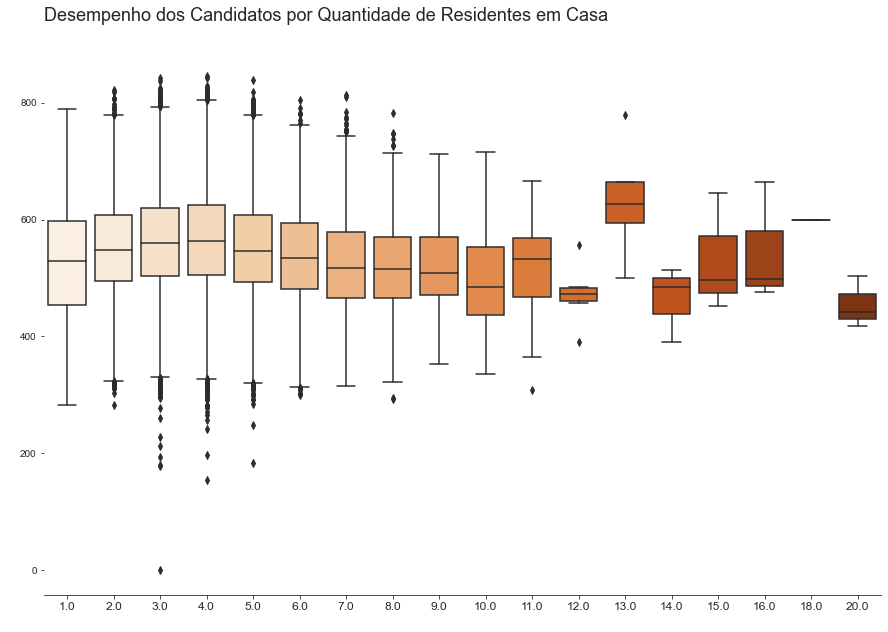

In [469]:
# Plotagem para faixas de renda
g8_residentes = sns.boxplot(y="NOTA_FINAL", x = "QTDE_RESIDENTES_CASA", 
    palette="Oranges", data=df)
g8_residentes.figure.set_size_inches(15,10)
plt.title('Desempenho dos Candidatos por Quantidade de Residentes em Casa', fontsize = 18, loc='left', pad=30)
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(fontsize = 12)
sns.despine (left = True)
sns.set_style('ticks')